In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [2]:
def update_state(c,b1,b2,omega_tab,gamma,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k1, 1_k2, 0>
    b (np array): Atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * np.sqrt(gamma/(2*L)) * np.exp(-1j * (omega_tab - omega_A) * t) 
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))


    c_new = b1[:,np.newaxis] @ np.conjugate(g_matrix[np.newaxis,:]) + np.conjugate(g_matrix[:,np.newaxis]) @ b2[np.newaxis,:] 
    b1_new = c @ g_matrix
    b2_new = g_matrix @ c

    return -1j* dt * c_new, -1j * dt * b1_new, -1j * dt * b2_new

def RG_scheme(c_init, b1_init, b2_init, omega_tab, gamma, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k1, 1_k2, 0>
    b_init (np array): initial atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(omega_tab)
    c_array = np.zeros((nb_pts_time, 2*n_modes, 2*n_modes), dtype=complex)
    b1_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b2_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b1_array[0] = b1_init
    b2_array[0] = b2_init
    
    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b1_current = b1_array[i-1]
        b2_current = b2_array[i-1]

        c_new_k1, b1_new_k1, b2_new_k1 = update_state(c_current, b1_current, b2_current, omega_tab, gamma, omega_A, L, t, dt)
        c_new_k2, b1_new_k2, b2_new_k2 = update_state(c_current + c_new_k1/2, b1_current + b1_new_k1/2, b2_current + b2_new_k1/2, omega_tab, gamma, omega_A, L, t + dt/2, dt)
        c_new_k3, b1_new_k3, b2_new_k3  = update_state(c_current + c_new_k2/2, b1_current + b1_new_k2/2, b2_current + b2_new_k2/2, omega_tab, gamma, omega_A, L, t + dt/2, dt)
        c_new_k4, b1_new_k4, b2_new_k4 = update_state(c_current + c_new_k3, b1_current + b1_new_k3, b2_current + b2_new_k3, omega_tab, gamma, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b1_new = b1_current + (b1_new_k1 + 2*b1_new_k2 + 2*b1_new_k3 + b1_new_k4) / 6
        b2_new = b2_current + (b2_new_k1 + 2*b2_new_k2 + 2*b2_new_k3 + b2_new_k4) / 6

        c_array[i] = c_new
        b1_array[i] = b1_new
        b2_array[i] = b2_new

    return c_array, b1_array, b2_array 
    

<h1> Function that treats the whole evolution </h1>

In [3]:
def get_data_bs_fast(L, T, dt, omega_0, omega_A, gamma, omega_max, sigma, x_0, x_1, print_info = False, progress_bar=True):
    """
    Generate data for the RG scheme with a beamsplitter.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the first Gaussian peak.
    x_1 (float): Position of the second Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k1, 1_k2, 0>.
    b_array (np array): Coefficients in front of the state |1_k, 1>.
    overlap_tab (np array): Array of overlaps with the initial state.
    """
    
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_p) #only positive modes
    n_modes = len(k_tab_individual) #number of modes in each waveguide
    omega_tab_individual = np.abs(k_tab_individual)

    if print_info:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    if print_info:
        print("Preparing the initial state...")
    c_init = np.zeros((2*n_modes, 2*n_modes), dtype=complex)
    b1_init = np.zeros(2*n_modes, dtype=complex)
    b2_init = np.zeros(2*n_modes, dtype=complex)


    c_a_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_0)
    c_a = np.concatenate((c_a_individual, np.zeros(n_modes))) #put it in the first waveguide

    c_b_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_1)
    c_b = np.concatenate((np.zeros(n_modes), c_b_individual)) #put it in the second waveguide

    c_init = c_a[:, np.newaxis] * c_b[np.newaxis, :]
    c_init = (c_init + c_init.T)
    norm = np.sqrt(np.sum(np.abs(c_init)**2))
    c_init /= norm

    ##evolve the state
    if print_info:
        print("Evolving the state...")
    c_array, b1_array, b2_array = RG_scheme(c_init, b1_init, b2_init, omega_tab_individual, gamma, omega_A, L, T, dt, progress_bar=progress_bar)


    return c_array, b1_array, b2_array, k_tab_individual

<h1> First test </h1>

Some checks

In [22]:
L = 30*pi
T = L/2
dt = 0.01

#Bare parameters
gamma = 4
omega_A = 5
omega_max = 15 

#renormalized parameters
prefactor = 1/(1-gamma/(2*pi)*(1/omega_A + 1/(omega_max - omega_A)))
omega_A_phys = omega_A - gamma / (2*pi) * np.log((omega_max-omega_A)/omega_A) * prefactor
gamma_phys = gamma * prefactor

#initial photon wavepacket parameters
omega_0 = omega_A_phys - gamma_phys/2
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4

delta_x = 0*sigma
x_1 = x_0 + delta_x

#check some parameters
#check some parameters
print("50% Reflectivity for omega_0_m = ", omega_A_phys - gamma/2, " and omega_0_p = ", omega_A_phys + gamma/2)
print("Value of gamma", gamma, "and sigma_momentum = ", sigma_momentum)

50% Reflectivity for omega_0_m =  2.4545568271289016  and omega_0_p =  6.4545568271289016
Value of gamma 4 and sigma_momentum =  0.08488263631567752


Run the calculations

In [23]:
c_array, b1_array, b2_array, k_tab_individual = get_data_bs_fast(L, T, dt, omega_0, omega_A, gamma, omega_max, sigma, x_0, x_1, print_info = False, progress_bar=True)

  0%|          | 0/4711 [00:00<?, ?it/s]

<h1> Coherence and atom excitation </h1>

In [24]:
time_array = np.linspace(0, T, int(T / dt))
nb_pts_time = int(T / dt)
n_modes = c_array.shape[1] // 2

c_11 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_12 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_21 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)
c_22 = np.zeros((nb_pts_time, n_modes, n_modes), dtype=complex)

p_11 = np.zeros(nb_pts_time)
p_12 = np.zeros(nb_pts_time)
p_21 = np.zeros(nb_pts_time)
p_22 = np.zeros(nb_pts_time)

atom_excitation = np.zeros(nb_pts_time)
#get the number of modes

for i in tqdm(range(nb_pts_time)):
    c_current, b1_current, b2_current = c_array[i], b1_array[i], b2_array[i]

    atom_excitation[i] = np.sum(np.abs(b1_current)**2) + np.sum(np.abs(b2_current)**2)
    p_11[i] = np.sum(np.abs(c_current[:n_modes, :n_modes])**2)
    p_12[i] = np.sum(np.abs(c_current[:n_modes, n_modes:])**2)
    p_21[i] = np.sum(np.abs(c_current[n_modes:, :n_modes])**2)
    p_22[i] = np.sum(np.abs(c_current[n_modes:, n_modes:])**2)

  0%|          | 0/4712 [00:00<?, ?it/s]

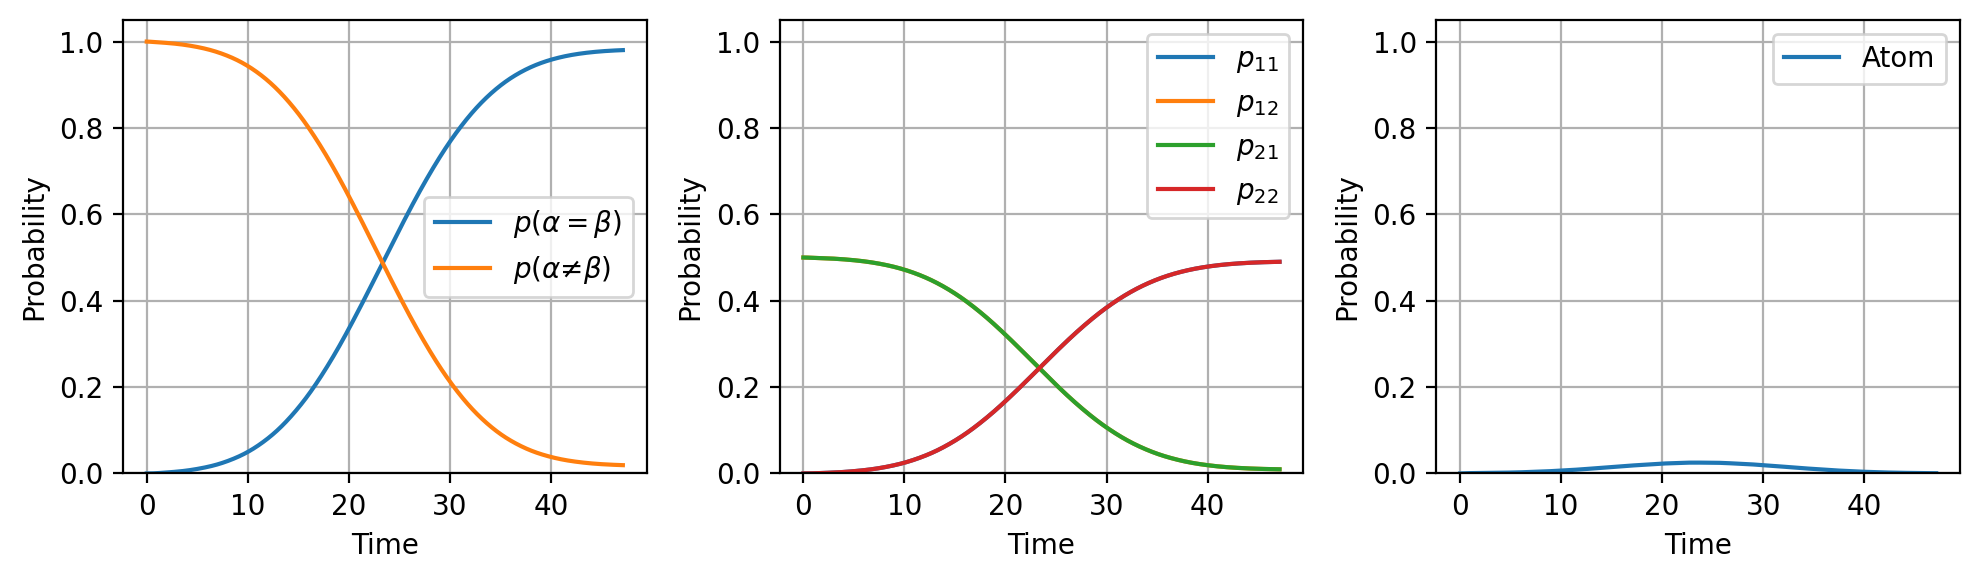

In [25]:
fig, ax = plt.subplots(1,3, figsize=(10,3), dpi=resol)

ax[0].plot(time_array, p_11 + p_22, label=r'$p(\alpha = \beta)$')
ax[0].plot(time_array, p_12 + p_21, label=r'$p(\alpha \ne \beta)$')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Probability')
ax[0].legend()
ax[0].grid()
ax[0].set_ylim([0,1.05])


ax[1].plot(time_array, p_11, label="$p_{11}$")
ax[1].plot(time_array, p_12, label="$p_{12}$")
ax[1].plot(time_array, p_21, label="$p_{21}$")
ax[1].plot(time_array, p_22, label="$p_{22}$")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Probability')
ax[1].legend()
ax[1].grid()
ax[1].set_ylim([0,1.05])


ax[2].plot(time_array, atom_excitation,label='Atom')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Probability')
ax[2].legend()
ax[2].grid()
ax[2].set_ylim([0,1.05])

fig.tight_layout()
plt.show()

Sanity check : HOM effect

In [26]:
print("anti HOM probability ", 1 - p_11[-1] - p_22[-1])
print("Theoretical value: ", 0.5 * (1 - (1 - 1/(np.sqrt(2*pi) * sigma * gamma))*np.exp(-0.5 * (delta_x / sigma)**2)))

anti HOM probability  0.01972356772946543
Theoretical value:  0.0042329090622827414


Visualize wave function in both channels

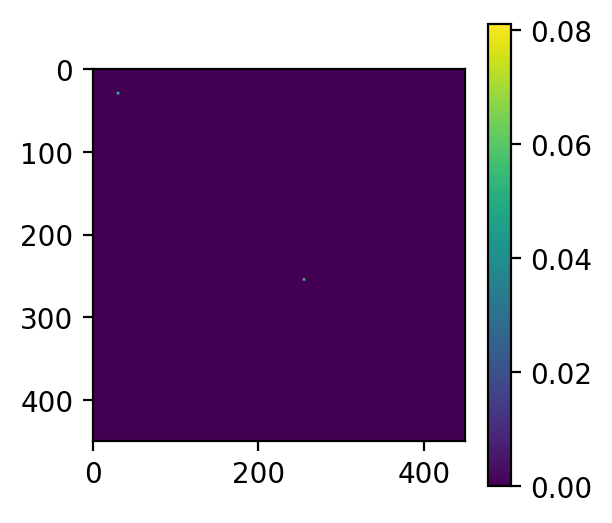

In [27]:
time_index = -1
c_current = c_array[time_index]
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
im = ax.imshow(np.abs(c_current)**2)
plt.colorbar(im, ax=ax)
plt.show()

<h1> HOM anti bunch at fixed delays </h1>

We examine the probability $p(\alpha \ne \beta)$ against the ratio $\kappa = \sigma / \tau$, where $\tau^{-1} = \Gamma = \gamma / 2$

In [19]:
L = 20*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 10
omega_max = 20

omega_A_phys = 10
g_0_phys = 0.538

gamma = g_0_phys**2 * omega_A_phys
tau = 1 / (2*gamma)
omega_0 = omega_A_phys + gamma

x_0 = -L/4

nb_pts_sigma = 15
sigma_tab = np.linspace(L/8, L/64, nb_pts_sigma)

time_delay_tab = 10*pi*np.array([0,1/16,2/16,3/16])
nb_pts_time_delay = 4

p_HOM_tab = np.zeros((nb_pts_sigma, nb_pts_time_delay))

for i in tqdm(range(nb_pts_sigma)):
    for j in range(nb_pts_time_delay):
        time_delay = time_delay_tab[j]
        print("Treating time delay ", time_delay)

        x_1 = x_0 - time_delay
        sigma = sigma_tab[i]
        c_array, b1_array, b2_array, k_tab_individual  = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=False)
        n_modes = len(k_tab_individual)

        p_11_final = np.sum(np.abs(c_array[-1, :n_modes, :n_modes])**2)
        p_22_final = np.sum(np.abs(c_array[-1, n_modes:, n_modes:])**2)
        p_HOM_tab[i,j] = p_11_final + p_22_final
        
    print("----------------")


  0%|          | 0/15 [00:00<?, ?it/s]

Treating time delay  0.0


KeyboardInterrupt: 

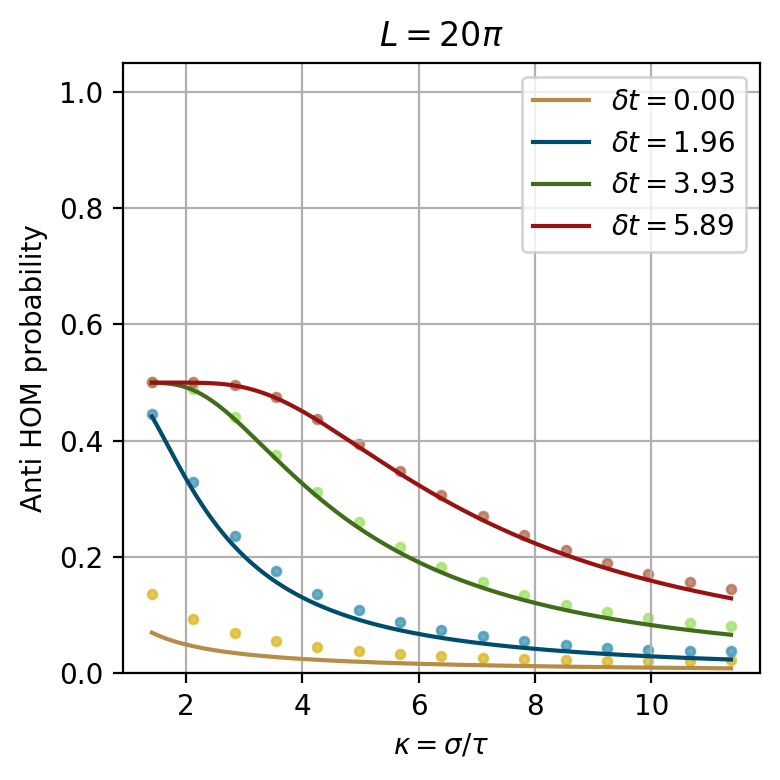

In [18]:
#get theoretical curve
sigma_tab_th = 20*pi*np.linspace(1/8, 1/64, 1000)

fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=resol)

color_th = ["#b58d47", "#004c6d", "#416d1b", "#991212"]
color_simu = ["#dbb930", "#4599b6", "#a2e26e","#b67257"]

for j in range(nb_pts_time_delay):

    time_delay = time_delay_tab[j]
    p_anti_HOM_th = 0.5 * (1 - (1 - 1/(np.sqrt(2*pi) * sigma_tab_th * gamma))*np.exp(-0.5 * (time_delay / sigma_tab_th)**2))

    ax.scatter(sigma_tab*gamma/2, 1-p_HOM_tab[:,j], s=10, color=color_simu[j], alpha=0.8)
    ax.plot(sigma_tab_th*gamma/2, p_anti_HOM_th, label = rf'$\delta t = {time_delay:.2f}$', color=color_th[j])


ax.set_xlabel(r'$\kappa = \sigma / \tau$')
ax.set_ylabel(r'Anti HOM probability')
ax.set_title(r'$L = 20\pi$')
ax.set_ylim([0,1.05])
#ax.set_xlim([0.5,5.5])
ax.grid()
ax.legend()


fig.tight_layout()
plt.show()

<h1> HOM anti bunch against time delay </h1>

In [26]:
L = 10*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.5
omega_A = 10
omega_max = 20

omega_A_phys = 10
g_0_phys = 0.538

gamma = g_0_phys**2 * omega_A_phys
omega_0 = omega_A_phys + gamma

#initial photon wavepacket parameters
sigma = L/32
sigma_momentum = 1/sigma
x_0 = -L/4

#prepare several values of delta_x
nb_pts_x = 9
time_delay_tab = np.linspace(-3*sigma, 3*sigma, nb_pts_x)
p_11_tab = np.zeros(nb_pts_x)
p_22_tab = np.zeros(nb_pts_x)

for i in tqdm(range(nb_pts_x)):
    x_1 = x_0 + time_delay_tab[i]
    c_array, b1_array, b2_array, k_tab_individual  = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=False)
    n_modes = len(k_tab_individual)
    p_11_tab[i] = np.sum(np.abs(c_array[-1, :n_modes, :n_modes])**2)
    p_22_tab[i] = np.sum(np.abs(c_array[-1, n_modes:, n_modes:])**2)



  0%|          | 0/9 [00:00<?, ?it/s]

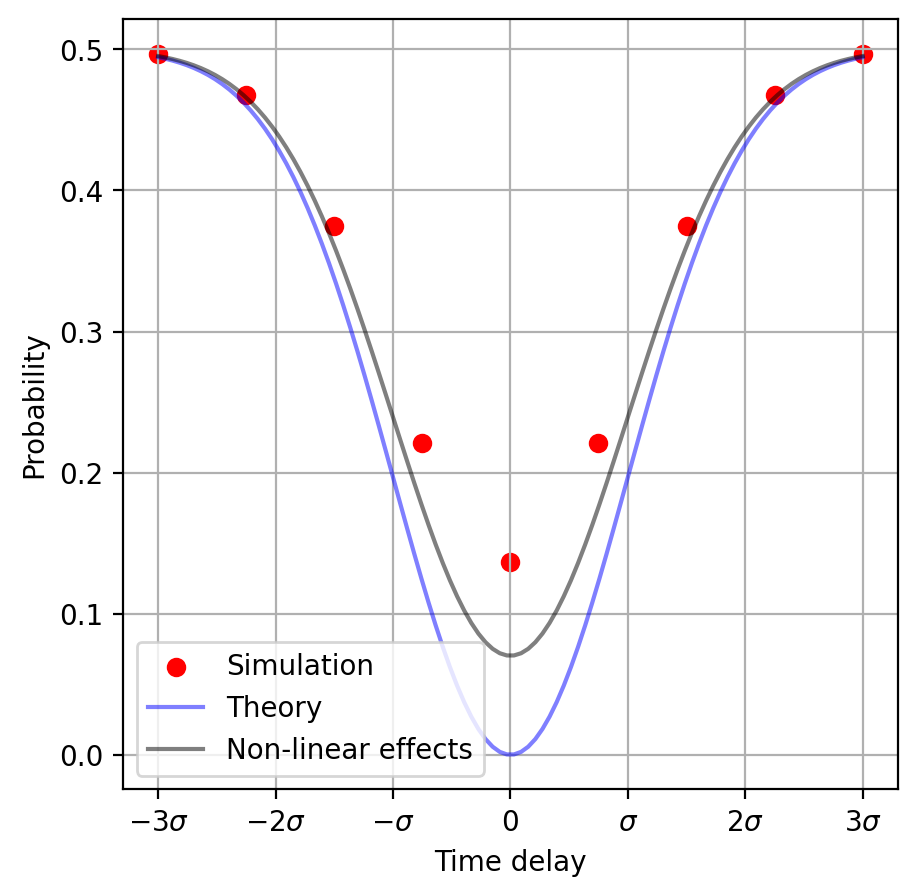

In [27]:
time_delay_th = np.linspace(-3*sigma, 3*sigma, 100)
anti_HOM_proba_total = 0.5 * (1 - (1 - 1/(np.sqrt(2*pi) * sigma * gamma))*np.exp(-0.5 * (time_delay_th / sigma)**2))
anti_HOM_monochr = 0.5 * ( 1 - np.exp(-0.5 * (time_delay_th / sigma)**2))

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=resol)

ax.scatter(time_delay_tab, 1-p_11_tab-p_22_tab, label="Simulation", color='red')
ax.plot(time_delay_th, anti_HOM_monochr, label="Theory", color="blue", alpha=0.5)
ax.plot(time_delay_th, anti_HOM_proba_total, label="Non-linear effects", color="black", alpha=0.5)

ax.set_xlabel(r"Time delay")
ax.set_ylabel(r"Probability")
ax.set_xticks(np.array([-3,-2, -1, 0, 1, 2, 3])*sigma)
ax.set_xticklabels([r"$-3\sigma$", r"$-2\sigma$", r"$-\sigma$", "0", r"$\sigma$", r"$2\sigma$", r"$3\sigma$"])
ax.grid()
ax.legend(loc="lower left")
plt.show()